<a href="https://colab.research.google.com/github/ViktoriaZaremba/cv/blob/master/CV_lab3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


## Data Processing


In [41]:
import numpy as np 
import pandas as pd 
import os, time
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
import keras
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Dense, Dropout, Flatten
from keras.models import Model
from keras import models
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16;
from keras.applications.vgg16 import preprocess_input
import os

Юзайємо GPU бо сил ніяких нема стільки чекати поки воно натрейниться


In [42]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

### Loading the dataset from raw csv files.


In [43]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [44]:
train_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/fashion-mnist_train.csv')
test_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/fashion-mnist_test.csv')

In [45]:
train_data.shape
test_data.shape 
train_X= np.array(train_data.iloc[:,1:])
test_X= np.array(test_data.iloc[:,1:])
train_Y= np.array (train_data.iloc[:,0])
test_Y = np.array(test_data.iloc[:,0])

In [46]:
train_X.shape, test_X.shape

((60000, 784), (10000, 784))

In [47]:
classes = np.unique(train_Y)
num_classes = len(classes)
num_classes

10

А на  ILSVRC 200 класів!!!

А не 10

І ще вийшла накладка, бо VVG створений для триканальних зображень, а в наші доні чорнобілі (один канал). Тому шаманимо і перетворюємо на 3.

In [48]:
train_X=np.dstack([train_X] * 3)
test_X=np.dstack([test_X]*3)
train_X.shape,test_X.shape

((60000, 784, 3), (10000, 784, 3))

### Reshaping images as per the tensor format required by tensorflow


Таке ж робиться в методичі...

In [49]:
train_X = train_X.reshape(-1, 28,28,3)
test_X= test_X.reshape (-1,28,28,3)
train_X.shape,test_X.shape

((60000, 28, 28, 3), (10000, 28, 28, 3))

In [50]:
train_X = train_X / 255.
test_X = test_X / 255.
train_X = train_X.astype('float32')
test_X = test_X.astype('float32')

In [51]:
from keras.preprocessing.image import img_to_array, array_to_img
train_X = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48,48))) for im in train_X])
test_X = np.asarray([img_to_array(array_to_img(im, scale=False).resize((48,48))) for im in test_X])
train_X.shape, test_X.shape

((60000, 48, 48, 3), (10000, 48, 48, 3))

In [52]:
# Нормальлізуємо дані і міняємо формат
train_X = train_X / 255.
test_X = test_X / 255.
train_X = train_X.astype('float32')
test_X = test_X.astype('float32')

### Converting Labels to one hot encoded format


In [53]:
train_Y_one_hot = to_categorical(train_Y)
test_Y_one_hot = to_categorical(test_Y)

### Splitting train data as train and validation data


In [54]:
train_X,valid_X,train_label,valid_label = train_test_split(train_X,
                                                           train_Y_one_hot,
                                                           test_size=0.2,
                                                           random_state=13
                                                           )

In [55]:
train_X.shape,valid_X.shape,train_label.shape,valid_label.shape

((48000, 48, 48, 3), (12000, 48, 48, 3), (48000, 10), (12000, 10))

#### Defining the parameters for instanitaing VGG16 model. 


In [56]:
IMG_WIDTH = 48
IMG_HEIGHT = 48
IMG_DEPTH = 3
BATCH_SIZE = 16

#### Preprocessing the input 


In [57]:
#оце вже функція з архтектури
train_X = preprocess_input(train_X)
valid_X = preprocess_input(valid_X)
test_X  = preprocess_input (test_X)

### VGG-16 From Keras Library

* `include_top`  - Чи використовувати перші три fully-connected layers. То класно використовувати, коли маємо 100500 класів (тобто взагалі алгоритм заточений під 1000 з ImageNet, але в нас ільки 10, того немає в тому потреби)

* `input_shape`: тут треба вказати, бо в нас include_top - false, і розмір не (255,255, 3), як в класичному варіанті



In [58]:
conv_base = keras.applications.vgg16.VGG16(
                  include_top=False, 
                  input_shape=(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH)
                 )
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 48, 48, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 48, 48, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 48, 48, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 24, 24, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 24, 24, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 24, 24, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 12, 12, 128)       0     

## Training the Model

* Extracting features

In [59]:
train_features = conv_base.predict(np.array(train_X), batch_size=BATCH_SIZE, verbose=1)
test_features = conv_base.predict(np.array(test_X), batch_size=BATCH_SIZE, verbose=1)
val_features = conv_base.predict(np.array(valid_X), batch_size=BATCH_SIZE, verbose=1)

750/750 [==============================] - 5s 7ms/step


* Save the features so that they can be used for future

In [60]:
np.savez("train_features", train_features, train_label)
np.savez("test_features", test_features, test_Y)
np.savez("val_features", val_features, valid_label)

* Shape of features

In [61]:
print(train_features.shape, "\n",  test_features.shape, "\n", val_features.shape)

(48000, 1, 1, 512) 
 (10000, 1, 1, 512) 
 (12000, 1, 1, 512)


In [62]:
# Flatten extracted features
train_features_flat = np.reshape(train_features, (48000, 1*1*512))
test_features_flat = np.reshape(test_features, (10000, 1*1*512))
val_features_flat = np.reshape(val_features, (12000, 1*1*512))

In [63]:
from keras import models
from keras.models import Model
from keras import layers
from tensorflow.keras import optimizers
from keras import callbacks
from keras.layers.advanced_activations import LeakyReLU


##### Define the densely connected classifier followed by leakyrelu layer and final dense layer for the number of classes


In [64]:
NB_TRAIN_SAMPLES = train_features_flat.shape[0]
NB_VALIDATION_SAMPLES = val_features_flat.shape[0]
NB_EPOCHS = 100

model = models.Sequential()
model.add(layers.Dense(512, activation='relu', input_dim=(1*1*512)))
model.add(layers.LeakyReLU(alpha=0.1))
model.add(layers.Dense(num_classes, activation='softmax'))

##### Compiling the model.

In [65]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.Adam(),
    metrics=['acc'])

In [66]:
eary_stopping = callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=7,
    verbose=1,
    mode='auto')

callbacks = [reduce_learning, eary_stopping]

In [67]:
# Train the Model
history = model.fit(
    train_features_flat,
    train_label,
    epochs=50,
    validation_data=(val_features_flat, valid_label),
    callbacks=callbacks
)

Epoch 1/50
1500/1500 [==============================] - 5s 3ms/step - loss: 2.4295 - acc: 0.1007 - val_loss: 2.3275 - val_acc: 0.1007 - lr: 0.0010
Epoch 2/50
1500/1500 [==============================] - 4s 3ms/step - loss: 2.3439 - acc: 0.0963 - val_loss: 2.3079 - val_acc: 0.1040 - lr: 0.0010
Epoch 3/50
1500/1500 [==============================] - 4s 3ms/step - loss: 2.3063 - acc: 0.0987 - val_loss: 2.3028 - val_acc: 0.0976 - lr: 0.0010
Epoch 4/50
1500/1500 [==============================] - 4s 3ms/step - loss: 2.3027 - acc: 0.0984 - val_loss: 2.3026 - val_acc: 0.1018 - lr: 0.0010
Epoch 5/50
1500/1500 [==============================] - 4s 3ms/step - loss: 2.3028 - acc: 0.1004 - val_loss: 2.3031 - val_acc: 0.0946 - lr: 0.0010
Epoch 6/50
1499/1500 [============================>.] - ETA: 0s - loss: 2.3027 - acc: 0.0995
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
1500/1500 [==============================] - 4s 3ms/step - loss: 2.3027 - acc: 0.0995 - val_los

## Plots of Loss and Accuracy

* Plotting the Loss and Accuracy graphs

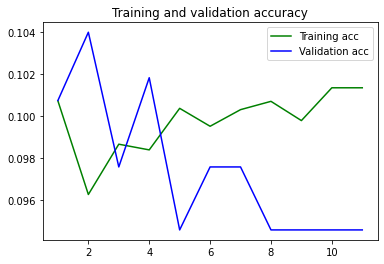

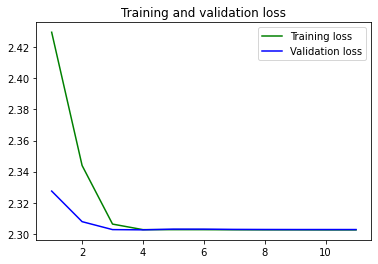

In [68]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, 'green', label='Training acc')
plt.plot(epochs, val_acc, 'blue', label='Validation acc')
plt.legend()

plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, 'green', label='Training loss')
plt.plot(epochs, val_loss, 'blue', label='Validation loss')

plt.legend()

plt.show()